## Quantize a Segmentation Model and Show Live Inference

In [4]:
"""
On Windows, try to find the directory that contains x64 cl.exe and add it to the PATH to enable PyTorch
to find the required C++ tools. This code assumes that Visual Studio is installed in the default
directory. If you have a different C++ compiler, please add the correct path to os.environ["PATH"]
directly. Note that the C++ Redistributable is not enough to run this notebook.

Adding the path to os.environ["LIB"] is not always required - it depends on the system's configuration
"""

from re import search
import sys

if sys.platform == "win32":
    import distutils.command.build_ext
    import os
    from pathlib import Path

    if sys.getwindowsversion().build >= 20000:
        search_path = "**/Hostx64/x64/cl.exe"    
    else:
        search_path = "**/Hostx86/x64/cl.exe"

    VS_INSTALL_DIR_2019 = r"C:/Program Files (x86)/Microsoft Visual Studio"
    VS_INSTALL_DIR_2022 = r"C:/Program Files/Microsoft Visual Studio"

    cl_paths_2019 = sorted(list(Path(VS_INSTALL_DIR_2019).glob(search_path)))
    cl_paths_2022 = sorted(list(Path(VS_INSTALL_DIR_2022).glob(search_path)))
    cl_paths = cl_paths_2019 + cl_paths_2022

    if len(cl_paths) == 0:
        raise ValueError(
            """
            Cannnot find Visual Studio. This notebook requires an x64 C++ compiler. If you installed a
            C++ compiler, please add the directory that contains cl.exe to `os.environ[PATH]`
            """
        )

    else:
        cl_path = cl_paths[-1]
        vs_dir = str(cl_path.parent)
        os.environ["PATH"] += f"{os.pathsep}{vs_dir}"
        d =  distutils.core.Distribution()
        b = distutils.command.build_ext.build_ext(d)
        b.finalize_options()
        os.environ["LIB"] = os.pathsep.join(b.library_dirs)
        print(f"Added {vs_dir} to PATH")

Added C:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\bin\Hostx64\x64 to PATH


In [5]:
import logging
import os
import sys
import time
import random
from tkinter.ttk import Notebook
import warnings
import zipfile
from pathlib import Path

warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
from monai.transforms import LoadImage
from nncf.common.utils.logger import set_log_level
from openvino.inference_engine import IECore
from openvino.runtime import Core
from torch.jit import TracerWarning
from torchmetrics import F1

set_log_level(logging.ERROR)

sys.path.append("../utils/")
from models.custom_segmentation import SegmentationModel
from notebook_utils import NotebookAlert, benchmark_model, download_file, show_live_inference

try:
    import subprocess
    from nncf import NNCFConfig
    from nncf.torch import create_compressed_model, register_default_init_args
except subprocess.CalledProcessError:
    message = "WARNING: Running this notebook requires an x64 C++ compiler"
    NotebookAlert(message=message, alert_class="warning")


### Settings

In [6]:
BASEDIR = Path("kits19_frames_1")
# Uncomment the line below to use the full dataset, as prepared in the data preparation notebook
# BASEDIR = Path("~/kits19/kits19_frames").expanduser()
MODEL_DIR = Path("model")
MODEL_DIR.mkdir(exist_ok=True)

### Load PyTorch model

In [8]:
state_dict_url = "https://github.com/helena-intel/openvino_notebooks/raw/110-nncf/notebooks/110-ct-segmentation-quantize/pretrained_model/unet_kits19_state_dict.pth"
state_dict_file = download_file(state_dict_url, directory="pretrained_model")
state_dict = torch.load(state_dict_file, map_location=torch.device("cpu"))

new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("_model.", "")
    new_state_dict[new_key] = v
new_state_dict.pop("loss_function.pos_weight")

model = monai.networks.nets.BasicUNet(spatial_dims=2, in_channels=1, out_channels=1).eval()
model.load_state_dict(new_state_dict)

pretrained_model\unet_kits19_state_dict.pth:   0%|          | 0.00/7.58M [00:00<?, ?B/s]

BasicUNet features: (32, 32, 64, 128, 256, 32).


<All keys matched successfully>

In [9]:
dummy_input = torch.randn(1, 1, 512, 512)
fp32_onnx_path = MODEL_DIR / "unet_kits19_fp32.onnx"
torch.onnx.export(model, dummy_input, fp32_onnx_path)
!mo --input_model "$fp32_onnx_path" --output_dir $MODEL_DIR

c:\Users\hokuto\Desktop\practice\LearnOpenVino\.openvino-venv\lib\site-packages\monai\networks\nets\basic_unet.py:179: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x_e.shape[-i - 1] != x_0.shape[-i - 1]:


Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	c:\Users\hokuto\Desktop\practice\LearnOpenVino\008Quantization_Segmentation\model\unet_kits19_fp32.onnx
	- Path for generated IR: 	c:\Users\hokuto\Desktop\practice\LearnOpenVino\008Quantization_Segmentation\model
	- IR output name: 	unet_kits19_fp32
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced paramete

### Download CT-scan Data

In [16]:
# The CT scan case number. For example: 2 for data from the case_00002 directory
# Currently only 117 is supported
CASE = 117
if not (BASEDIR / f"case_{CASE:05d}").exists():
    BASEDIR.mkdir(exist_ok=True)
    filename = download_file(
        f"https://storage.openvinotoolkit.org/data/test_data/openvino_notebooks/kits19/case_{CASE:05d}.zip"
    )

    # debug
    print(filename)

    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall(path=BASEDIR)
        print(f"Downloaded and extracted data for case_{CASE:05d}")
else:
    print(F"Data for case_{CASE:05d} exists")

# remove zip file
os.remove(filename)

Data for case_00117 exists


## Configration

### Dataset

In [19]:
def rotate_and_flip(image):
    """Rotate `image` by 90 degrees and flip horizontally"""
    return cv2.flip(cv2.rotate(image, rotateCode=cv2.ROTATE_90_CLOCKWISE), flipCode=1)

class KitsDataset:
    def __init__(self, basedir:str):
        """
        Dataset class for prepared kits19 data, for binary segmentation (background/kidney)
        Source data should exist in basedir, in subdirectories case_0000 until case_00210,
        with each subdirectory containing directories imaging_frames, with jpg images, and
        segmentation_frames with segmentation masks as png files.
        See https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/110-ct-segmentation-quantize/data-preparation-ct-scan.ipynb

        :param basedir: Directory that contains the prepared CT scans
        """

        masks = sorted(BASEDIR.glob("case_*/segmentation_frames/*png"))

        self.basedir = basedir
        self.dataset = masks
        print(
            f"""
            Created dataset with {len(self.dataset)} items.
            Base directory for data: {basedir}
            """
        )

    def __getitem__(self, index):
        """
        Get an item from the dataset ath the specified index.

        :return : (image, segmentation_mask)
        """

        mask_path = self.dataset[index]
        image_path = str(mask_path.with_suffix(".jpg")).replace(
            "segmentation_frames", "imaging_frames"
        )

        # Load images with MONAI's LoadImage to match data loading in training notebook
        mask = LoadImage(image_only=True, dtype=np.uint8)(str(mask_path))
        img = LoadImage(image_only=True, dtype=np.float32)(str(image_path))

        if img.shape[:2] != (512, 512):
            img = cv2.resize(img.astype(np.uint8), (512, 512)).astype(np.float32)
            mask = cv2.resize(mask, (512, 512))

        input_image = np.expand_dims(img, axis=0)
        return input_image, mask

    def __len__(self):
        return len(self.dataset)


            Created dataset with 69 items.
            Base directory for data: kits19_frames_1
            


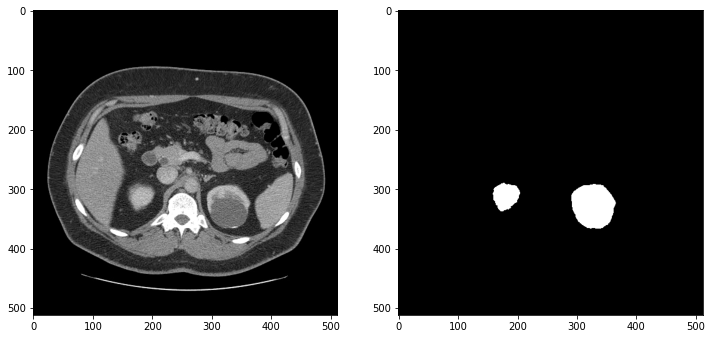

In [20]:
dataset = KitsDataset(BASEDIR)
# Find a slice that contains kindney annotations
# item[0] is the annotation: (id, annotation_data)
image_data, mask = next(item for item in dataset if np.count_nonzero(item[1]) > 5000)

# Remove extra image dimenstion and rotate and flip the image for visualization
image = rotate_and_flip(image_data.squeeze())

# The data loader returns annotations as (index, mask) and mask in shape (H, W)
mask = rotate_and_flip(mask)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap="gray")
ax[1].imshow(mask, cmap="gray")

### Metric

In [21]:
def compute_f1(model: torch.nn.Module, dataset: KitsDataset):
    """
    Compute binary F1 score of `model` on `dataset`
    F1 score metric is provided by the torchmetirc library
    `model` is expected to be a binary segmentation model, images in the 
    dataet are expected in (N, C, H, W) format where N==C==1
    """

    metric = F1(ignore_index=0)
    with torch.no_grad():
        for image, target in dataset:
            input_image = torch.as_tensor(image).unsqueeze(0)
            output = model(input_image)
            label = torch.as_tensor(target.squeeze()).long()
            prediction = torch.sigmoid(output.squeeze()).round().long()
            metric.update(label.flatten(), prediction.flatten())

    return metric.compute()

### Quantization

In [22]:
fp32_f1 = compute_f1(model, dataset)
print(f"FP32 F1: {fp32_f1:.3f}")

FP32 F1: 0.974


In [ ]:
"""
NNCF uses the model loaded at the beginning of this notebook. If after quantizing the model,
you want to quantize with a different config, reload the model by uncommenting the next tow lines
"""

# model = monai.networks.nets.BasicUNet(spatial_dims=2, in_channels=1, out_channels=1).eval()
# model.load_state_dict(new_state_dict)

nncf_config_dict = {
    "input_info": {"sample_size": [1, 1, 512, 512]},
    "target_device": "CPU",
    "compression":{
        "algorithm": "quantization",
        "preset": "performance",
        "ignored_scopes": ["{re}.*LeakyReLU"],
    },
}

nncf_config = NNCFConfig.from_dict(nncf_config_dict)

### ここから先のプログラムはデスクトップ推奨

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4)
nncf_config = register_default_init_args(nncf_config, data_loader)
compression_ctrl, compressed_model = create_compressed_model(model, nncf_config)

In [ ]:
compressed_model

In [ ]:
int8_onnx_path = MODEL_DIR / "unet_kits19_int8.onnx"
warnings.filterwarnings("ignore", category=TracerWarning)
warnings.filterwarnings("ignore", category=UserWarning)
compression_ctrl.export_model(str(int8_onnx_path))
print(f"INT8 ONNX model exported to {int8_onnx_path}")

!mo --input_model "$int8_onnx_path" --input_shape "[1, 1 512, 512]" --output_dir "$MODEL_DIR"

## Compare FP32 and INT8 model

### Compare File Size

In [ ]:
fp32_ir_path = Path(fp32_onnx_path).with_suffix(".xml")
int8_ir_path = Path(int8_onnx_path).with_suffix(".xml")

original_model_size = fp32_ir_path.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = int8_ir_path.with_suffix(".bin").stat().st_size / 1024

print(f"FP32 model size: {original_model_size:.2f}KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")

### Compare Metrics

In [ ]:
int8_f1 = compute_f1(compressed_model, dataset)

print(f"FP32 F1: {fp32_f1:.3f}")
print(f"INT8 F1: {int8_f1:.3f}")

### Compare Performance of the Original and Quantized Models

In [ ]:
# Show the parameters and docstring for `benchmark_model`
benchmark_model?

In [ ]:
device = "CPU"

In [ ]:
# Benchmark FP32 model
benchmark_model(model_path=fp32_ir_path, device=device, seconds=15)

In [ ]:
# Benchmark INT8 model
benchmark_model(model_path=int8_ir_path, device=device, seconds=15)

### Visually Compare Inference Results

In [ ]:
# The sigmoid function is used to transform the result of the network
# to binary segmentation masks

def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

num_images = 4
colormap = "gray"

# Loat FP32 and INT8 models
core = Core()
fp_model = core.read_model(fp32_ir_path)
int8_model = core.read_model(int8_ir_path)
compiled_model_fp = core.compile_model(fp_model, device_name="CPU")
compiled_model_int8 = core.compile_model(int8_model, device_name="CPU")
output_layer_fp = compiled_model_fp.output(0)
output_layer_int8 = compiled_model_int8.output(0)

# Create subset of dataset
background_slices = (item for item in dataset if np.count_nonzero(item[1]) == 0)
kindney_slices = (item for item in dataset if np.count_nonzero(item[1]) > 50)
data_subset = random.sample(list(background_slices), 2) + random.sample(list(kindney_slices), 2)

# Set seed to current time. To reproduce specific results, copy the printed
# and manually set `read` to that value
seed = int(time.time())
random.seed(seed)
print(f"Visualizing results with seed {seed}")

fig, ax = plt.subplots(nrows=num_images, ncols=4, figsize=(24, num_images * 4))
for i, (image, mask) in enumerate(data_subset):
    display_image = rotate_and_flip(image.squeeze())
    target_mask = rotate_and_flip(mask).astype(np.uint8)

    # Add batch dimension to image and do inference on FP and INT8 models
    input_image = np.expand_dims(image, 0)
    res_fp = compiled_model_fp([input_image])
    res_int8 = compiled_model_int8([input_image])

    # Process inference outputs and convert to binary segmentation masks
    result_mask_fp = sigmoid(res_fp[output_layer_fp]).squeeze().round().astype(np.uint8)
    result_mask_int8 = sigmoid(res_int8[output_layer_int8]).squeeze().round().astype(np.uint8)
    result_mask_fp = rotate_and_flip(result_mask_fp)
    result_mask_int8 = rotate_and_flip(result_mask_int8)

    # Display images, annotations, FP32 result and INT8 result
    ax[i, 0].imshow(display_image, cmap=colormap)
    ax[i, 1].imshow(target_mask, cmap=colormap)
    ax[i, 2].imshow(result_mask_fp, cmap=colormap)
    ax[i, 3].imshow(result_mask_int8, cmap=colormap)
    ax[i, 2].set_title("Prediction on FP32 model")
    ax[i, 3].set_title("Prediction on INT8 model")

### Load model and list of image files

In [ ]:
CASE = 117

# The live inference function uses the OpenVINO Runtime API which is compatible with
# OpenVINO LTS release 2021.4

ie = IECore()
segmentation_model = SegmentationModel(
    ie=ie, model_path=Path(int8_ir_path), sigmoid=True, rotate_and_flip=True
)

case_path = BASEDIR / f"case_{CASE:05d}"
image_paths = sorted(case_path.glob("imaging_frames/*jpg"))
print(f"{case_path.name}, {len(image_paths)} images")

### Show Inference

In [ ]:
# Possible options for device include CPU GPU AUTO MULTI:CPU,GPU
device = "CPU"
reader = LoadImage(image_only=True, dtype=np.uint8)
show_live_inference(
    ie=ie, image_paths=image_paths, model=segmentation_model, device=device, reader=reader
)